## EA Movie Recommendation Predict


Introduction We are developing a mobile recommendation algorithm that utilizes content-based or collaborative filtering techniques. This algorithm accurately predicts how users will rate movies they haven’t seen yet, based on their historical preferences. Recommender systems play a crucial role in helping individuals make informed choices about the content they engage with daily, both socially and economically.

![image.png](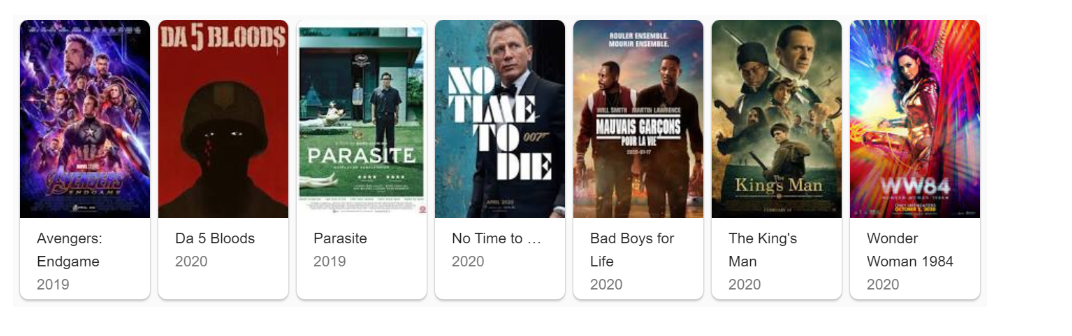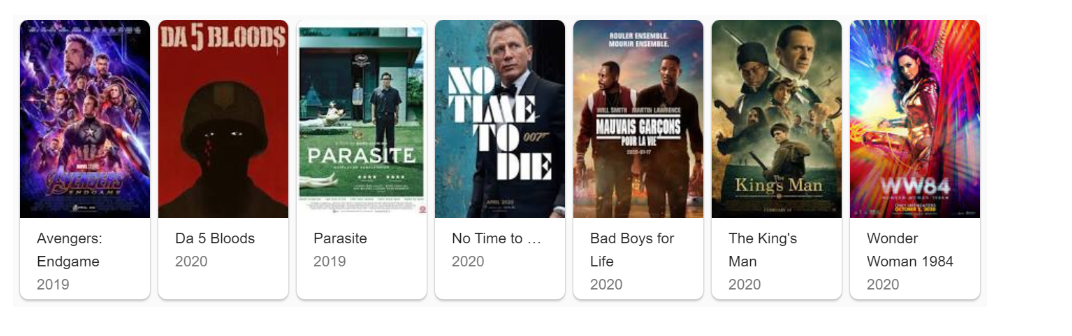)

## Table of Contents

1. Importing Packages</a>

2. Loading Data</a>

3. Exploratory Data Analysis (EDA)</a>

4. Data Engineering</a>

5. Modeling</a>

6. Model Performance</a>

7. Model Explanations</a>

# 1. Importing Packages


In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import re
import nltk


import os
import seaborn as sns
import io
from zipfile import ZipFile

!pip install nltk

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Loading the Data

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/train.csv')
df_tags = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/tags.csv')
df_links = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/links.csv')
df_imdb = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/imdb_data.csv')
df_genome = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/genome_tags.csv')
df_gen_scores = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/genome_scores.csv')
df_movies = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/movies.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ea-movie-recommendation-predict-2023-2024/test.csv')


# 3. Exploratory Data Analysis (EDA)

**Train**

In [4]:
#first five column for train dataset
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1.518350e+09
1,106343,5,4.5,1.206239e+09
2,146790,5459,5.0,1.076216e+09
3,106362,32296,2.0,1.423043e+09
4,9041,366,3.0,8.333758e+08


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7748475 entries, 0 to 7748474
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  float64
dtypes: float64(2), int64(2)
memory usage: 236.5 MB


In [6]:
train_null = df_train.isnull().sum()

print(f"We have {train_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(train_null[train_null > 0])

We have 2 null values in our train dataset
Columns with null values and their counts:
rating       1
timestamp    1
dtype: int64


In [7]:
rows, cols = df_train.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 7748475 rows and 4 columns, that's in this format (7748475, 4)


**Test**

In [8]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [10]:
test_null = df_test.isnull().sum()

print(f"We have {test_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(test_null[test_null > 0])

We have 0 null values in our train dataset
Columns with null values and their counts:
Series([], dtype: int64)


In [11]:
rows, cols = df_test.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 5000019 rows and 2 columns, that's in this format (5000019, 2)


**Movies**

In [12]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [14]:
movie_null = df_movies.isnull().sum()

print(f"We have {movie_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(movie_null[movie_null > 0])

We have 0 null values in our train dataset
Columns with null values and their counts:
Series([], dtype: int64)


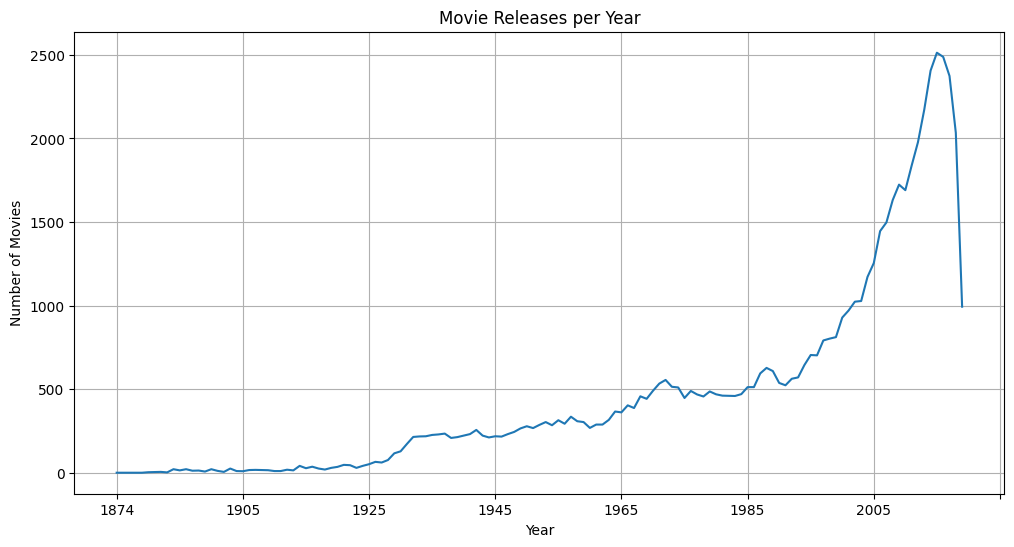

In [58]:
movies_per_year = df_movies['year'].value_counts().sort_index()

# Create a line plot
movies_per_year.plot(kind='line', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Movie Releases per Year')
plt.grid(True)
plt.show()

In [15]:
rows, cols = df_movies.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 62423 rows and 3 columns, that's in this format (62423, 3)


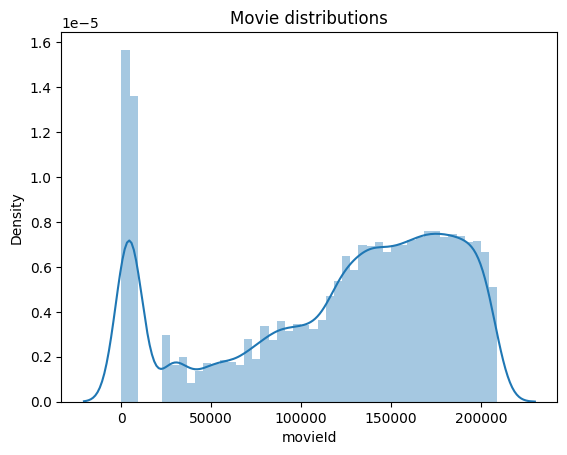

In [57]:
sns.distplot(df_movies['movieId'])
plt.title('Movie distributions')
plt.show()

**Tags**

In [16]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [17]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [18]:
tags_null = df_tags.isnull().sum()

print(f"We have {tags_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(tags_null[tags_null > 0])

We have 16 null values in our train dataset
Columns with null values and their counts:
tag    16
dtype: int64


In [19]:
rows, cols = df_tags.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 1093360 rows and 4 columns, that's in this format (1093360, 4)


KeyError: "None of [Index(['timestamp'], dtype='object')] are in the [columns]"

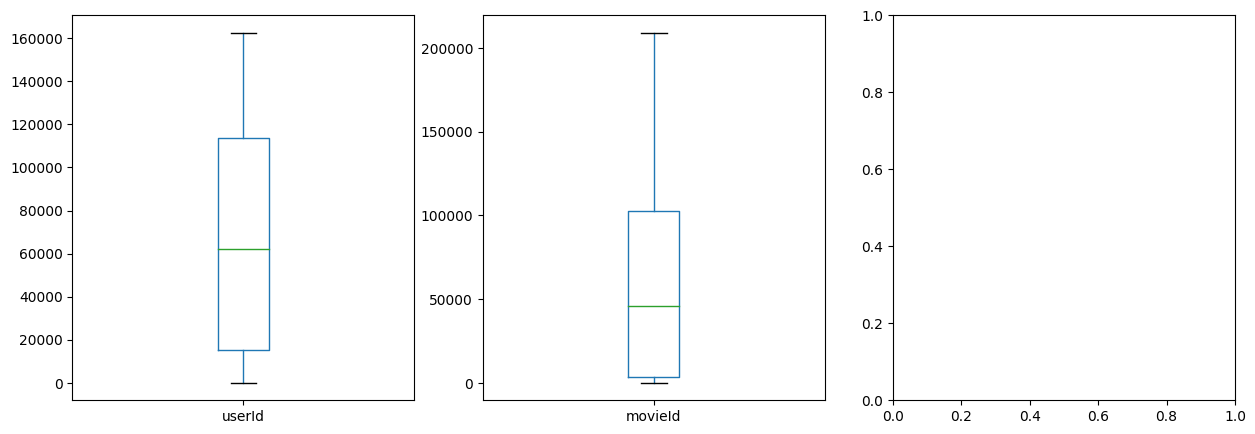

In [60]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df_tags.boxplot(column=['userId'], grid=False, ax=axs[0])
df_tags.boxplot(column=['movieId'], grid=False, ax=axs[1])
df_tags.boxplot(column=['timestamp'], grid=False, ax=axs[2])

# Set titles for each subplot
axs[0].set_title('User ID Distribution')
axs[1].set_title('Movie ID Distribution')
axs[2].set_title('Timestamp Distribution')

fig.text(0.5, 0.04, 'Values', ha='center', va='center')

# Set common x-axis label
fig.text(0.04, 0.5, 'Boxplot', ha='center', va='center', rotation='vertical')


plt.show()


**Links**

In [20]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [21]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [22]:
links_null = df_links.isnull().sum()

print(f"We have {links_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(links_null[links_null > 0])

We have 107 null values in our train dataset
Columns with null values and their counts:
tmdbId    107
dtype: int64


In [23]:
rows, cols = df_links.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 62423 rows and 3 columns, that's in this format (62423, 3)


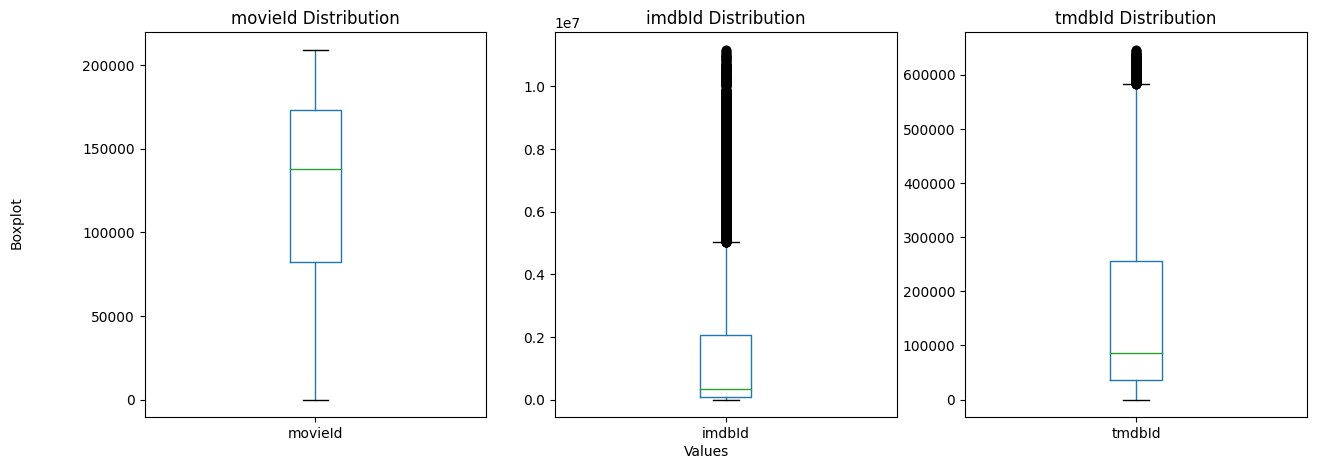

In [66]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df_links.boxplot(column=['movieId'], grid=False, ax=axs[0])
df_links.boxplot(column=['imdbId'], grid=False, ax=axs[1])
df_links.boxplot(column=['tmdbId'], grid=False, ax=axs[2])

# Set titles for each subplot
axs[0].set_title('movieId Distribution')
axs[1].set_title('imdbId Distribution')
axs[2].set_title('tmdbId Distribution')

fig.text(0.5, 0.04, 'Values', ha='center', va='center')

# Set common x-axis label
fig.text(0.04, 0.5, 'Boxplot', ha='center', va='center', rotation='vertical')

plt.show()


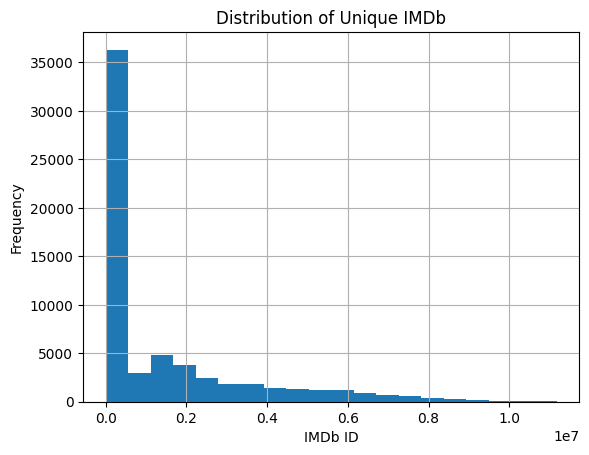

In [67]:
import matplotlib.pyplot as plt

# Plot the distribution
df_links['imdbId'].hist(bins=20)
plt.title('Distribution of Unique IMDb')
plt.xlabel('IMDb ID')
plt.ylabel('Frequency')
plt.show()


**imdb**

In [24]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [25]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [26]:
imdb_null= df_imdb.isnull().sum()

print(f"We have {imdb_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(imdb_null[imdb_null > 0])

We have 62481 null values in our train dataset
Columns with null values and their counts:
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


In [27]:
rows, cols = df_imdb.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 27278 rows and 6 columns, that's in this format (27278, 6)


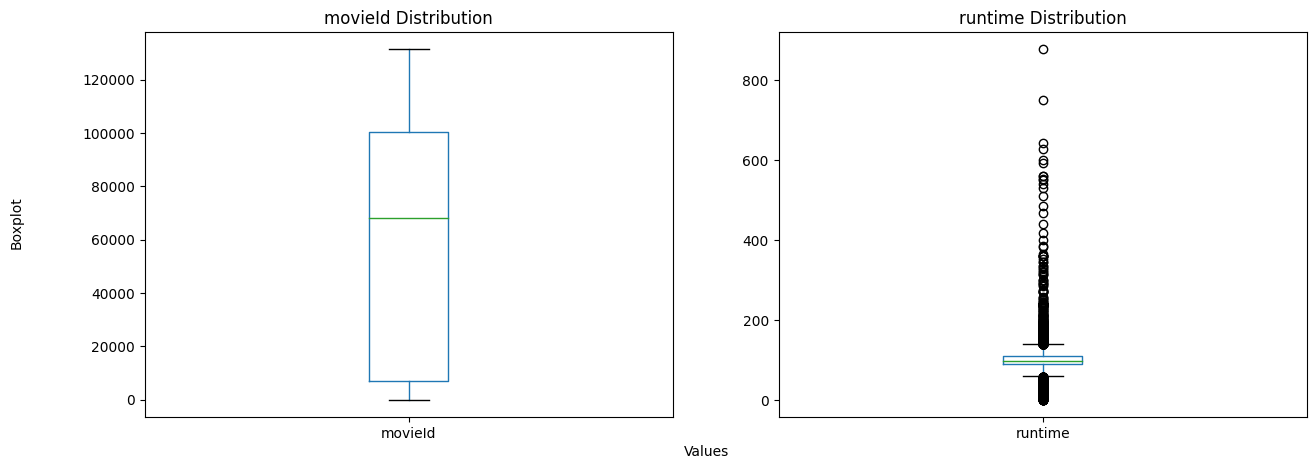

In [68]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df_imdb.boxplot(column=['movieId'], grid=False, ax=axs[0])
df_imdb.boxplot(column=['runtime'], grid=False, ax=axs[1])


# Set titles for each subplot
axs[0].set_title('movieId Distribution')
axs[1].set_title('runtime Distribution')


fig.text(0.5, 0.04, 'Values', ha='center', va='center')

# Set common x-axis label
fig.text(0.04, 0.5, 'Boxplot', ha='center', va='center', rotation='vertical')

plt.show()

**Genome**

In [28]:
df_genome.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [29]:
df_genome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [30]:
genome_null= df_genome.isnull().sum()

print(f"We have {genome_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(genome_null[genome_null > 0])

We have 0 null values in our train dataset
Columns with null values and their counts:
Series([], dtype: int64)


In [31]:
rows, cols = df_genome.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 1128 rows and 2 columns, that's in this format (1128, 2)


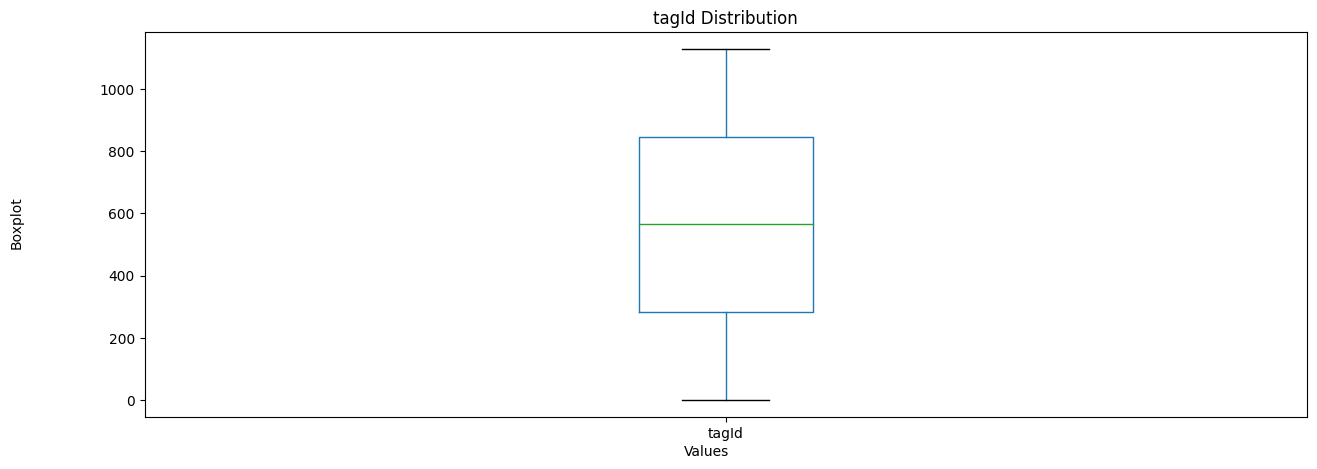

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot the boxplot
df_genome.boxplot(column=['tagId'], grid=False, ax=ax)

# Set title for the subplot
ax.set_title('tagId Distribution')

# Set common y-axis label
fig.text(0.5, 0.04, 'Values', ha='center', va='center')

# Set common x-axis label
fig.text(0.04, 0.5, 'Boxplot', ha='center', va='center', rotation='vertical')

plt.show()


**Genome Score**

In [32]:
df_gen_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [33]:
df_gen_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [34]:
gen_scores_null= df_gen_scores.isnull().sum()

print(f"We have {gen_scores_null.sum()} null values in our train dataset")

# Print the columns with their respective null counts
print("Columns with null values and their counts:")
print(gen_scores_null[gen_scores_null > 0])

We have 0 null values in our train dataset
Columns with null values and their counts:
Series([], dtype: int64)


In [35]:
rows, cols = df_gen_scores.shape
print(f"We have {rows} rows and {cols} columns, that's in this format ({rows}, {cols})")

We have 15584448 rows and 3 columns, that's in this format (15584448, 3)


Text(0.5, 1.0, 'Correlation Heatmap')

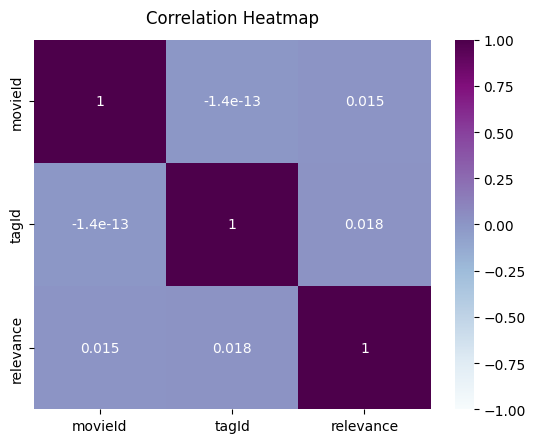

In [36]:
heatmap = sns.heatmap(df_gen_scores.corr(numeric_only=True), vmin=-1, vmax=1,cmap="BuPu", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)



#3. Data Engineering

We will consolidate the dataframes into a single one for further dataset analysis.


In [37]:
#extract year from title
movies = df_movies.copy() # Create a new copy of the Movies dataframe

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)', expand=False)

df_movies['title'] = df_movies['title'].str.replace(r'\(\d{4}\)', '').str.strip()

#remove year from title column
df_movies['title'] = df_movies['title'].str.replace(r'\s\(\d{4}\)', '', regex=True)

#getting rid of any ending whitespace characters that may have appeared
df_movies['title'] = df_movies['title'].apply(lambda x: x.strip())
df_movies.head()



,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [38]:
#df_train['timestamp'] = df_train['timestamp'].apply(lambda ts: pd.to_datetime(ts, unit='s'))


In [39]:

lemmatizer =nltk.WordNetLemmatizer()
tags= df_tags.copy()
# Clean and lemmatize tags
df_tags['tag'] = df_tags['tag'].apply(lambda x: lemmatizer.lemmatize(re.sub(r'\W+', ' ', str(x).lower())))

# Split genres into separate columns
#df_movies['genres'] = df_movies['genres'].apply(lambda x: str(x).split('|'))


In [40]:
#df_tags['timestamp'] = df_tags['timestamp'].apply(lambda ts: pd.to_datetime(ts, unit='s'))


In [41]:
df_movies['genres'] = df_movies['genres'].str.replace('|', ' ').str.lower()

df_imdb['title_cast'] = df_imdb['title_cast'].str.replace('|', ' ').str.lower()
df_imdb['plot_keywords'] = df_imdb['plot_keywords'].str.replace('|', ' ').str.lower()


In [42]:
df_imdb['director'] = df_imdb['director'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()


In [43]:

import pandas as pd
import re

# Define a function to clean and extract relevant parts
def clean_and_extract(title):
    # Remove unwanted characters and convert to lowercase
    title_clean = re.sub(r'[^a-zA-Z0-9\s]', '', title).lower()
    # Remove common patterns like "part ii" and standalone numbers
    title_clean = re.sub(r'part\s+\w+|\d+', '', title_clean).strip()
    # Return the cleaned title
    return title_clean

# Apply the function to the 'title' column in df_movies
df_movies['title'] = df_movies['title'].apply(clean_and_extract)

# Join the cleaned titles
joined_titles = ' '.join(df_movies['title'])



In [44]:
df_imdb['budget'] = df_imdb['budget'].str.extract(r'\$(\d{1,3}(?:,\d{3})*)(?:\.\d+)?')[0].str.replace(',', '').astype(float)


In [45]:

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# Extract datetime features
df_train['year_train'] = df_train['timestamp'].dt.year
df_train['month_train'] = df_train['timestamp'].dt.month
df_train['day_train'] = df_train['timestamp'].dt.day
df_train['hour_train'] = df_train['timestamp'].dt.hour
df_train['minute_train'] = df_train['timestamp'].dt.minute
df_train['second_train'] = df_train['timestamp'].dt.second

In [46]:
df_train.drop(columns=['timestamp'], inplace=True)


In [47]:
df_tags['timestamp'] = pd.to_datetime(df_tags['timestamp'])

# Extract datetime features
df_tags['year_tag'] = df_tags['timestamp'].dt.year
df_tags['month_tag'] = df_tags['timestamp'].dt.month
df_tags['day_tag'] = df_tags['timestamp'].dt.day
df_tags['hour_tag'] = df_tags['timestamp'].dt.hour
df_tags['minute_tag'] = df_tags['timestamp'].dt.minute
df_tags['second_tag'] = df_tags['timestamp'].dt.second

In [48]:
df_tags.drop(columns=['timestamp'], inplace=True)


In [49]:
df_train_movie = pd.merge(df_train, df_movies, on='movieId', how='inner')

# Merge the result with df3
df_final= pd.merge(df_train_movie, df_imdb, on='movieId', how='inner')

df_final= pd.merge(df_train_movie, df_imdb, on='movieId', how='inner')
df_final.head()

,userId,movieId,rating,year_train,month_train,day_train,hour_train,minute_train,second_train,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1970.0,1.0,1.0,0.0,0.0,1.0,in bruges,comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjo...,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman
1,87388,57669,3.5,1970.0,1.0,1.0,0.0,0.0,1.0,in bruges,comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjo...,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman
2,137050,57669,4.0,1970.0,1.0,1.0,0.0,0.0,1.0,in bruges,comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjo...,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman
3,120490,57669,4.5,1970.0,1.0,1.0,0.0,0.0,1.0,in bruges,comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjo...,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman
4,50616,57669,4.5,1970.0,1.0,1.0,0.0,0.0,1.0,in bruges,comedy crime drama thriller,2008,elizabeth berrington rudy blomme olivier bonjo...,martin mcdonagh,107.0,15000000.0,dwarf bruges irish hitman


In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7464304 entries, 0 to 7464303
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   year_train     float64
 4   month_train    float64
 5   day_train      float64
 6   hour_train     float64
 7   minute_train   float64
 8   second_train   float64
 9   title          object 
 10  genres         object 
 11  year           object 
 12  title_cast     object 
 13  director       object 
 14  runtime        float64
 15  budget         float64
 16  plot_keywords  object 
dtypes: float64(9), int64(2), object(6)
memory usage: 968.1+ MB


In [51]:
final_features = df_final.select_dtypes(include=["int64", "float64","int32"])

# Print the numerical features
print(final_features.columns.tolist())

['userId', 'movieId', 'rating', 'year_train', 'month_train', 'day_train', 'hour_train', 'minute_train', 'second_train', 'runtime', 'budget']


In [52]:
df_tags.head()

,userId,movieId,tag,year_tag,month_tag,day_tag,hour_tag,minute_tag,second_tag
0,3,260,classic,1970,1,1,0,0,1
1,3,260,sci fi,1970,1,1,0,0,1
2,4,1732,dark comedy,1970,1,1,0,0,1
3,4,1732,great dialogue,1970,1,1,0,0,1
4,4,7569,so bad it s good,1970,1,1,0,0,1


In [53]:
df_tags['tag'].head(30)

0                            classic
1                             sci fi
2                        dark comedy
3                     great dialogue
4                   so bad it s good
5               unreliable narrators
6                              tense
7            artificial intelligence
8                      philosophical
9                              tense
10                  so bad it s good
11                            cliche
12                           musical
13                            horror
14                     unpredictable
15    oscar best supporting actress 
16                         adventure
17                             anime
18                           ecology
19                           fantasy
20                    hayao miyazaki
21                          miyazaki
22                  post apocalyptic
23                               bah
24                    clint eastwood
25                             music
26                               art
2

In [54]:
df_gen = pd.merge(df_gen_scores,df_genome, how = 'left',on = 'tagId')
df_gen.head()

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


In [55]:
#df_gen_movies = pd.merge(df_gen,df_train_movie,on='movie_id', how='outer')
#df_gen_movies.head()

#4. Modelling


In [ ]:
mgm

In [ ]:
!pip install surprise

In [ ]:
!pip install --upgrade surprise


In [ ]:
from surprise import Dataset, Reader
from surprise import accuracy

from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD

reader = Reader()

# Select only the relevant columns
df_selected_columns = df_train[['userId', 'movieId', 'rating']]

# Check for missing values and handle them
df_selected_columns = df_selected_columns.dropna()

# Check for infinite values and handle them
df_selected_columns = df_selected_columns[~df_selected_columns.isin([float('inf'), float('-inf')]).any(axis=1)]

# Create a Reader instance with the appropriate rating scale
reader = Reader(rating_scale=(0, 5))

# Load the data from the selected columns DataFrame
data = Dataset.load_from_df(df_selected_columns, reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

### **SVD Model**

In [ ]:
svd_model = SVD()

cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# Train the model on the trainset
svd_model.fit(trainset)

# Predict ratings for the testset
predictions = svd_model.test(testset)

# Evaluate the model
accuracy.rmse(predictions)

### **SVD Model 2**

In [ ]:
# Define  hyperparameters
parameters = {'n_factors': 1000, 'reg_all': 0.02, 'lr_all': 0.0085, 'n_epochs': 20}

svd_model_2 = SVD(n_factors=parameters['n_factors'], reg_all=parameters['reg_all'], lr_all=parameters['lr_all'], n_epochs=parameters['n_epochs'])

svd_model_2.fit(trainset)

predictions = svd_model_2.test(testset)

accuracy.rmse(predictions)

### **SlopeOne**

In [ ]:
#from surprise import SlopeOne

#slope_one_model = SlopeOne()

#cross_validate(slope_one_model, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

#slope_one_model.fit(trainset)

# Predict ratings
#predictions = slope_one_model.test(testset)

#accuracy.rmse(predictions)

### **BaselineOnly**

In [ ]:
from surprise import BaselineOnly

baseline_model = BaselineOnly()

cross_validate(baseline_model, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

baseline_model.fit(trainset)

predictions = baseline_model.test(testset)

accuracy.rmse(predictions)

In [ ]:
xkjs

### Submition

In [ ]:
# Predict the ratings for the df_test dataset
df_test['rating'] = df_test.apply(lambda x: svd_model.predict(str(x.get('userId', '')), str(x.get('movieId', ''))).est, axis=1)

# Create the Id column
df_test['Id'] = df_test.apply(lambda x: f"{int(x.get('userId', 0))}_{int(x.get('movieId', 0))}", axis=1)

# Reorder the columns
df_test = df_test[['Id', 'rating']]

# Save the predictions to a CSV file
df_test.to_csv('Sub_Svd.csv', index=False)

In [ ]:
files.download('Sub_Svd.csv')
